### Import libraries for Deep Learning

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: ', {device})

Using device:  {device(type='cuda')}


In [ ]:
path = '/content/drive/My Drive/Colab Notebooks/Datasets/catsvsdogs'

In [ ]:
transform = transforms.Compose([
        transforms.Resize([224,224]),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

In [ ]:
full_dataset = datasets.ImageFolder(path, transform=transform)

FileNotFoundError: ignored

In [ ]:
len(full_dataset)

4895

In [ ]:
TRAIN_SIZE =  int(len(full_dataset) * 0.8) +1
VAL_SIZE = int(len(full_dataset) * 0.1 )
TEST_SIZE = int(len(full_dataset) * 0.1)
BATCH_SIZE = 64

In [ ]:
print(TRAIN_SIZE, VAL_SIZE, TEST_SIZE)
print(TRAIN_SIZE + VAL_SIZE + TEST_SIZE)

3917 489 489
4895


In [ ]:
training_set, val_set, test_set = random_split(full_dataset, [TRAIN_SIZE, VAL_SIZE, TEST_SIZE])

In [ ]:
training_loader = DataLoader(dataset=training_set, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_set, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=True)

La imagen muestreada representa un: dog


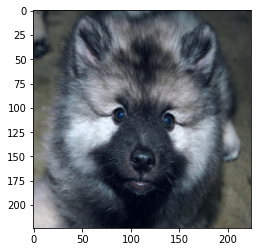

In [ ]:
# categories = ['Basset Hound', 'Beagle', 'Pug']
categories = ['cat', 'dog']
def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.show()

rnd_sample_idx = np.random.randint(TEST_SIZE)
print(f'La imagen muestreada representa un: {categories[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

In [ ]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi.squeeze()).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)

        return float(num_correct)/num_total     
            

In [ ]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for (xi, yi) in training_loader:
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi.squeeze())
#             cost = F.bin
        
            optimiser.zero_grad()           
            cost.backward()
            optimiser.step()           
            
        acc = accuracy(model, val_loader)
        if epoch%1 == 0:     
            print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()
    

In [ ]:
model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3,
                 padding=1, stride=1, bias=True),
        nn.BatchNorm2d(num_features=32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= (2, 2), stride=(2,2)),
    
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3,
                 padding=1, stride=1, bias=True),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= (2, 2), stride=(2,2)),
    
        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3,
                 padding=1, stride=1, bias=True),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= (2, 2), stride=(2,2)),
    
        nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3,
                 padding=1, stride=1, bias=True),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= (2, 2), stride=(2,2)),
    
        nn.Flatten(),
        nn.Linear(in_features = 14*14*128, out_features = 2, bias=True)
        )

In [ ]:
epochs = 30
num_classes = 2
# lr = 0.000031
lr = 0.001
optimizer = optim.Adam(params = model.parameters(), lr= lr)
train(model, optimizer, epochs)
acc = accuracy(model, val_loader)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Epoch: 0, costo: 0.9123561382293701, accuracy: 0.591002044989775,
Epoch: 1, costo: 0.917868971824646, accuracy: 0.656441717791411,
Epoch: 2, costo: 0.6873219609260559, accuracy: 0.6441717791411042,
Epoch: 3, costo: 0.8625676035881042, accuracy: 0.6707566462167689,
Epoch: 4, costo: 0.5792611837387085, accuracy: 0.6728016359918201,
Epoch: 5, costo: 0.5687732696533203, accuracy: 0.5971370143149284,
Epoch: 6, costo: 0.7904001474380493, accuracy: 0.721881390593047,
Epoch: 7, costo: 0.5510729551315308, accuracy: 0.7402862985685071,
Epoch: 8, costo: 0.20946985483169556, accuracy: 0.7730061349693251,
Epoch: 9, costo: 0.4688661992549896, accuracy: 0.7280163599182005,
Epoch: 10, costo: 0.432184636592865, accuracy: 0.7055214723926381,
Epoch: 11, costo: 0.3314017057418823, accuracy: 0.7321063394683026,
Epoch: 12, costo: 0.1616784781217575, accuracy: 0.7402862985685071,
Epoch: 13, costo: 0.2588416337966919, accuracy: 0.7116564417177914,
Epoch: 14, costo: 0.22277887165546417, accuracy: 0.75255623721

In [ ]:
print(acc)

In [ ]:
accuracy(model, test_loader)

In [ ]:
sum_y = 0
for i, (x, y) in enumerate(test_loader):
    print(i, x.shape, y)
    sum_y += sum(y)
print(sum_y)